<a href="https://colab.research.google.com/github/parmarsuraj99/numerai-guides/blob/master/Signals_Quandl/Signals_Quandl_EOD_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset used [End of Day US Stock Prices](https://www.quandl.com/data/EOD-End-of-Day-US-Stock-Prices/)

In [ ]:
!pip install numerapi
!pip install quandl

# 1. Libraries

In [3]:
import datetime
import gc
import logging
import os
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import numerapi
import numpy as np
import pandas as pd
import quandl
import requests
from dateutil.relativedelta import FR, relativedelta
from sklearn.ensemble import GradientBoostingRegressor

logging.basicConfig()

quandl_log = logging.getLogger("quandl")
quandl_log.setLevel(logging.DEBUG)

# 2. API key

In [4]:
API_KEY = "<Quandl API KEY>"
quandl.ApiConfig.api_key = API_KEY

In [ ]:
CURRENT_ROUND = 255

#3.  Data loading and Evaluation functions

In [ ]:
#From Jason Rosenfeld's notebook
#https://twitter.com/jrosenfeld13/status/1315749231387443202?s=20

def score(df):
    '''Takes df and calculates spearman correlation from pre-defined cols'''
    # method="first" breaks ties based on order in array
    return np.corrcoef(
        df[TARGET_NAME],
        df[PREDICTION_NAME].rank(pct=True, method="first")
    )[0,1]

def run_analytics(era_scores):
    print(f"Mean Correlation: {era_scores.mean():.4f}")
    print(f"Median Correlation: {era_scores.median():.4f}")
    print(f"Standard Deviation: {era_scores.std():.4f}")
    print('\n')
    print(f"Mean Pseudo-Sharpe: {era_scores.mean()/era_scores.std():.4f}")
    print(f"Median Pseudo-Sharpe: {era_scores.median()/era_scores.std():.4f}")
    print('\n')
    print(f'Hit Rate (% positive eras): {era_scores.apply(lambda x: np.sign(x)).value_counts()[1]/len(era_scores):.2%}')

    era_scores.rolling(10).mean().plot(kind='line', title='Rolling Per Era Correlation Mean', figsize=(15,4))
    plt.axhline(y=0.0, color="r", linestyle="--"); plt.show()

    era_scores.cumsum().plot(title='Cumulative Sum of Era Scores', figsize=(15,4))
    plt.axhline(y=0.0, color="r", linestyle="--"); plt.show()

## All at once

In [6]:
def download_full_and_load(ticker_map, common_tickers, f_name: str = "full_EOD.zip") -> pd.DataFrame:
    """Downloads a zip of entire dataset and load csv from it.
    Much faster!
    """

    url = f"https://www.quandl.com/api/v3/databases/EOD/data?api_key={API_KEY}"

    if os.path.exists(f_name):
        print(f"Using downloaded file {f_name}")
    else:
        print("Downloading data...")
        with requests.get(url, stream=True) as r:
            with open(f_name, "wb") as fin_data:
                for chunk in r.iter_content(chunk_size=1024):
                    fin_data.write(chunk)
            print(f"Saved as: {f_name}")

    # column names in the csv file without headers
    cols = [
        "ticker", "date", "Open", "High", "Low", "Close", "Volume", "Dividend",
        "Split", "Adj_Open", "Adj_High", "Adj_Low", "Adj_Close", "Adj_Volume",
    ]

    # usecols refers to the column in the csv.
    # using only [ticker, date, adj_open, adj_close]
    # Loading only needed columns as FP32
    print("loading from csv...")
    full_data = pd.read_csv(
        f_name,
        usecols=[0, 1, 9, 12],
        compression="zip",
        dtype={0: str, 1: str, 9: np.float32, 12: np.float32},
        header=None,
    )

    # renaming the columns
    filter_columns = ["ticker", "date", "Adj_Open", "Adj_Close"]
    full_data.columns = filter_columns
    full_data.set_index("date", inplace=True)
    full_data.index = pd.to_datetime(full_data.index)

    full_data.rename(
        columns={
            "Adj_Open": "open",
            "Adj_Close": "close",
        },
        inplace=True,
    )

    full_data[["open", "close"]] = full_data[["open", "close"]].astype(np.float32)
    full_data = full_data[full_data.ticker.isin(common_tickers)]
    full_data["bloomberg_ticker"] = full_data.ticker.map(
        dict(zip(ticker_map["yahoo"], ticker_map["bloomberg_ticker"]))
    )
    full_data.sort_index(ascending=True, inplace=True)
    gc.collect()

    return full_data

In [7]:
# -----Tickers and mapping-----
napi = numerapi.SignalsAPI()
eligible_tickers = pd.Series(napi.ticker_universe(), name="bloomberg_ticker")

ticker_map = pd.read_csv(
    "https://numerai-signals-public-data.s3-us-west-2.amazonaws.com/signals_ticker_map_w_bbg.csv"
)
ticker_map = ticker_map[ticker_map.bloomberg_ticker.isin(eligible_tickers)]

numerai_tickers = ticker_map["bloomberg_ticker"]
yfinance_tickers = ticker_map["yahoo"]

eod_tickers = pd.read_csv(
    "https://s3.amazonaws.com/quandl-production-static/end_of_day_us_stocks/ticker_list.csv"
)
print(f"Number of eligible tickers : {len(eligible_tickers)}")

common_tickers = np.intersect1d(
    yfinance_tickers.values.astype(str), eod_tickers["Ticker"].values.astype(str)
)
print(f"Number of tickers common between EOD and Bloomberg: {len(common_tickers)}")

# downloads the whole dataset as zip and read data (takes around 1.5min)
full_data = download_full_and_load(ticker_map, common_tickers, f_name="full_EOD.zip")

Number of eligible tickers : 5411
Number of tickers common between EOD and Bloomberg: 2234
Saved as: full_EOD.zip
loading from csv...


In [8]:
full_data

,ticker,open,close,bloomberg_ticker
date,,,,
1962-01-02,DIS,0.136265,0.136265,DIS US
1962-01-02,GE,0.303883,0.302870,GE US
1962-01-02,CAT,1.450237,1.450237,CAT US
1962-01-02,BA,0.845292,0.830672,BA US
1962-01-02,HPQ,0.177958,0.168338,HPQ US
...,...,...,...,...
2021-03-19,HOG,35.980000,35.250000,HOG US
2021-03-19,HOLX,71.220001,72.029999,HOLX US
2021-03-19,HOMB,27.639999,27.990000,HOMB US


# 4. Feature Engineering

In [9]:
def RSI(prices, interval=14):
    """Computes Relative Strength Index given a price series and lookback interval
    Modified from https://stackoverflow.com/questions/20526414/relative-strength-index-in-python-pandas
    See more here https://www.investopedia.com/terms/r/rsi.asp"""
    delta = prices.diff()

    dUp, dDown = delta.copy(), delta.copy()
    dUp[dUp < 0] = 0
    dDown[dDown > 0] = 0

    RolUp = dUp.rolling(interval).mean()
    RolDown = dDown.rolling(interval).mean().abs()

    RS = RolUp / RolDown
    RSI = 100.0 - (100.0 / (1.0 + RS))
    return RSI

In [10]:
#Building a custom feature
full_data["day_chg"] = full_data["close"]/full_data["open"] - 1 
gc.collect()

#----------
ticker_groups = full_data.groupby("bloomberg_ticker")

#RSI
full_data["close_RSI_14"] = ticker_groups["close"].transform(lambda x: RSI(x, 14))
full_data["close_RSI_21"] = ticker_groups["close"].transform(lambda x: RSI(x, 21))
full_data["day_chg_RSI_14"] = ticker_groups["day_chg"].transform(lambda x: RSI(x, 14))
full_data["day_chg_RSI_21"] = ticker_groups["day_chg"].transform(lambda x: RSI(x, 21))

#SMA
full_data["close_SMA_14"] = ticker_groups["close"].transform(
    lambda x: x.rolling(14).mean()
)
full_data["close_SMA_21"] = ticker_groups["close"].transform(
    lambda x: x.rolling(21).mean()
)

indicators = ["close_RSI_14", "close_RSI_21", "day_chg_RSI_14",
              "close_SMA_14", "close_SMA_21", "day_chg_RSI_21"]

full_data.dropna(axis=0, inplace=True)
del ticker_groups

#----------
date_groups = full_data.groupby(full_data.index)

for indicator in indicators:
    print(indicator)
    full_data[f"{indicator}_quintile"] = (
        date_groups[indicator]
        .transform(lambda group: pd.qcut(group, 100, labels=False, duplicates="drop"))
        .astype(np.float16)
    )
    gc.collect()

del date_groups
gc.collect()

#----------

ticker_groups = full_data.groupby("ticker")
# create lagged features, lag 0 is that day's value, lag 1 is yesterday's value, etc

for indicator in indicators:
    num_days = 5
    for day in range(num_days + 1):
        full_data[f"{indicator}_quintile_lag_{day}"] = ticker_groups[
            f"{indicator}_quintile"
        ].transform(lambda group: group.shift(day))

    gc.collect()

full_data.dropna(axis=0, inplace=True)

del ticker_groups
gc.collect()

# create difference of the lagged features (change in RSI quintile by day)
for indicator in indicators:
    for day in range(0, num_days):
        full_data[f"{indicator}_diff_{day}"] = (
            full_data[f"{indicator}_quintile_lag_{day}"]
            - full_data[f"{indicator}_quintile_lag_{day + 1}"]
        ).astype(np.float16)
        gc.collect()
        
    gc.collect()

# create difference of the lagged features (change in RSI quintile by day)
for indicator in indicators:
    full_data[f"{indicator}_abs_diff_{day}"] = np.abs(
        full_data[f"{indicator}_quintile_lag_{day}"]
        - full_data[f"{indicator}_quintile_lag_{day + 1}"]
    ).astype(np.float16)
    gc.collect()

close_RSI_14
close_RSI_21
day_chg_RSI_14
close_SMA_14
close_SMA_21
day_chg_RSI_21


In [11]:
TARGET_NAME = "target"
PREDICTION_NAME = "signal"

# read in Signals targets
numerai_targets = "https://numerai-signals-public-data.s3-us-west-2.amazonaws.com/signals_train_val_bbg.csv"
targets = pd.read_csv(numerai_targets)
targets["date"] = pd.to_datetime(targets["friday_date"], format="%Y%m%d")

# --------------ML DATA---------------

# merge our feature data with Numerai targets
ML_data = pd.merge(
    full_data.reset_index(), targets, on=["date", "bloomberg_ticker"]
).set_index("date")
print(f"Number of eras in data: {len(ML_data.index.unique())}")

# for training and testing we want clean, complete data only
ML_data.dropna(inplace=True)
ML_data = ML_data[ML_data.index.weekday == 4]  # ensure we have only fridays
ML_data = ML_data[
    ML_data.index.value_counts() > 200
]  # drop eras with under 200 observations per era
feature_names = [f for f in ML_data.columns for y in ["lag", "diff"] if y in f]
print(f"Using {len(feature_names)} features")

# --------------LIVE DATA---------------

last_friday = datetime.now() + relativedelta(weekday=FR(-1))
date_string = last_friday.strftime("%Y-%m-%d")

try:
    live_data = full_data.loc[date_string].copy()
except KeyError as e:
    print(f"No ticker on {e}")
    live_data = full_data.iloc[:0].copy()
live_data.dropna(subset=feature_names, inplace=True)

# get data from the day before, for markets that were closed
# on the most recent friday
last_thursday = last_friday - timedelta(days=1)
thursday_date_string = last_thursday.strftime("%Y-%m-%d")
thursday_data = full_data.loc[thursday_date_string]
# Only select tickers than aren't already present in live_data
thursday_data = thursday_data[
    ~thursday_data.ticker.isin(live_data.ticker.values)
].copy()
thursday_data.dropna(subset=feature_names, inplace=True)

live_data = pd.concat([live_data, thursday_data])

# --------------Train & test  Data---------------

# train test split
train_data = ML_data[ML_data["data_type"] == "train"].copy()
test_data = ML_data[ML_data["data_type"] == "validation"].copy()

train_data[feature_names]/=100.0
test_data[feature_names]/=100.0
live_data[feature_names]/=100.0

#del ML_data
gc.collect()

Number of eras in data: 911


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Using 72 features


0

In [ ]:
ML_data.to_csv("ML_data.csv", index=True)
live_data.to_csv("live_data.csv", index=True)

# 5. Model Training and prediction

In [12]:
# train model
print("Training model...")
model = GradientBoostingRegressor(n_estimators=50)
model.fit(train_data[feature_names], train_data[TARGET_NAME])
print("Model trained.")

# predict test data
train_data[PREDICTION_NAME] = model.predict(train_data[feature_names])
test_data[PREDICTION_NAME] = model.predict(test_data[feature_names])

print(f"Number of live tickers to submit: {len(live_data)}")
live_data[PREDICTION_NAME] = model.predict(live_data[feature_names])

Training model...
Model trained.
Number of live tickers to submit: 2233


In [17]:
# spearman scores by era
train_era_scores = train_data.groupby(train_data.index).apply(score)
test_era_scores = test_data.groupby(test_data.index).apply(score)
gc.collect()

488

Mean Correlation: 0.0367
Median Correlation: 0.0353
Standard Deviation: 0.0403


Mean Pseudo-Sharpe: 0.9104
Median Pseudo-Sharpe: 0.8746


Hit Rate (% positive eras): 81.80%


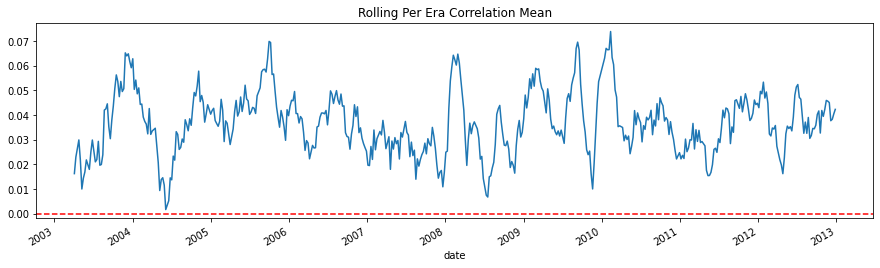

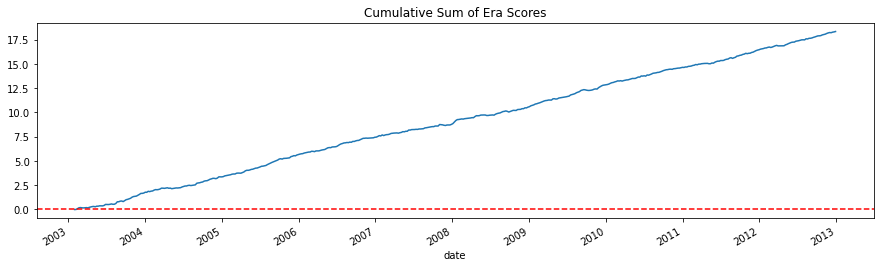

In [18]:
#train scores, in-sample and will be significantly overfit
run_analytics(train_era_scores)

Mean Correlation: 0.0091
Median Correlation: 0.0092
Standard Deviation: 0.0377


Mean Pseudo-Sharpe: 0.2414
Median Pseudo-Sharpe: 0.2431


Hit Rate (% positive eras): 62.77%


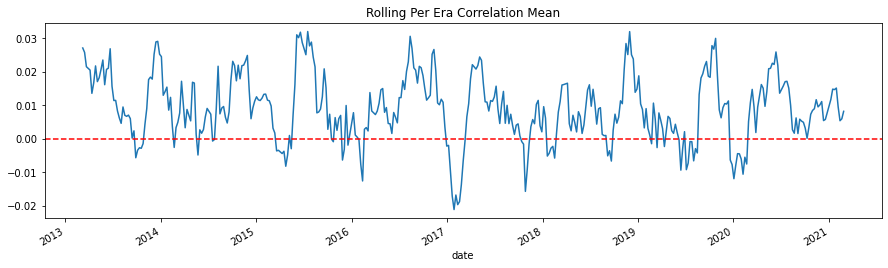

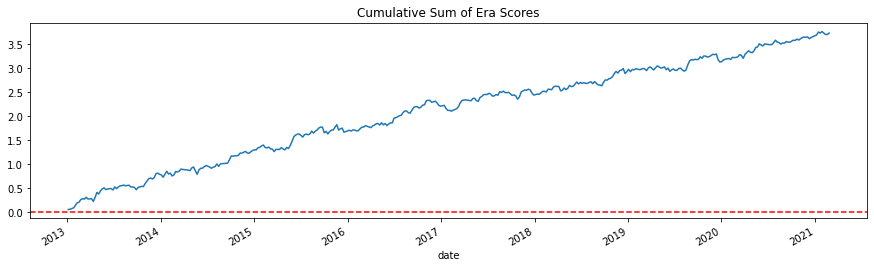

In [19]:
#test scores, out of sample
run_analytics(test_era_scores)

In [20]:
# prepare and writeout example file
diagnostic_df = pd.concat([test_data, live_data])
diagnostic_df["friday_date"] = diagnostic_df.friday_date.fillna(
    last_friday.strftime("%Y%m%d")
).astype(int)
diagnostic_df["data_type"] = diagnostic_df.data_type.fillna("live")
diagnostic_df[
    ["bloomberg_ticker", "friday_date", "data_type", "signal"]
].reset_index(drop=True).to_csv("example_quandl_signal_upload.csv", index=False)
print(
    "Example submission completed. Upload to signals.numer.ai for scores and live submission"
)

Example submission completed. Upload to signals.numer.ai for scores and live submission


## Submitting using Numerapi

In [ ]:
#MODEL_NAME

MODEL_NAME = "<MODEL_NAME>"

diagnostic_df[['bloomberg_ticker', 'friday_date', 'data_type','signal']].reset_index(drop=True).to_csv(
                    f'siganls_{MODEL_NAME}_{CURRENT_ROUND}.csv', index=False)

example_public_id = "<public ID>"
example_secret_key = "<secret key>"
napi = numerapi.SignalsAPI(example_public_id, example_secret_key)

model_id= "<model ID>"
napi.upload_predictions(f'siganls_{MODEL_NAME}_{CURRENT_ROUND}.csv',
                        model_id=model_id)